In [6]:
%matplotlib inline
from utils.dataloader import CODDataset
dataset = CODDataset("./Dataset/TrainDataset", use_augmentation=True)
sample = dataset[0]
img, gt = sample['img'], sample['gt']

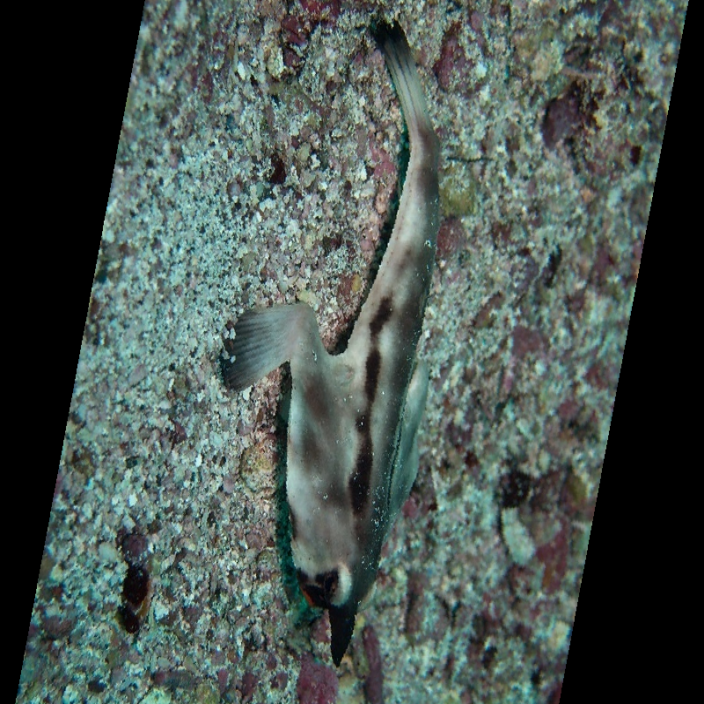

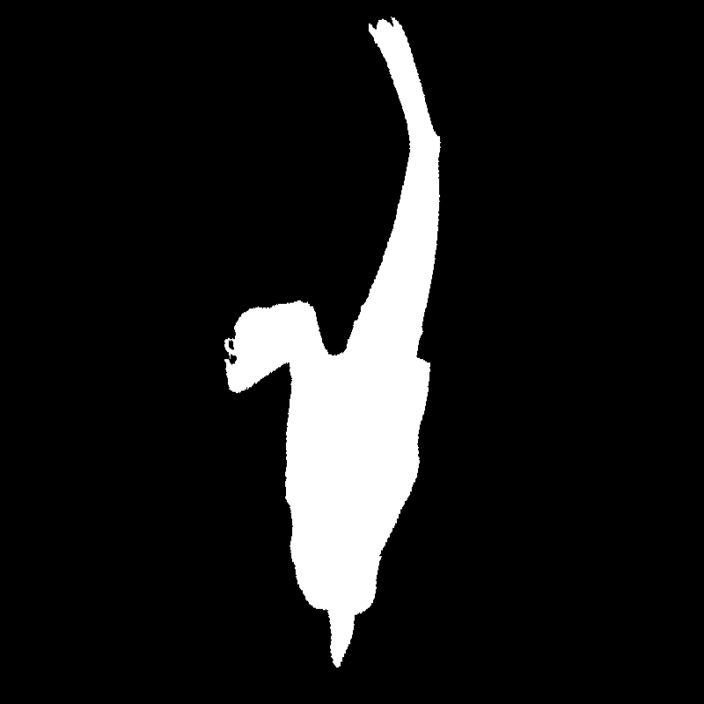

In [7]:
from IPython.display import display
import torchvision.transforms.functional as TF

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 恢复原始图像
img_restored = img.clone()  # 首先复制标准化后的图像张量，以免改变原始数据
for i in range(3):  # 遍历每个通道
    img_restored[i, :, :] *= std[i]  # 乘以标准差
    img_restored[i, :, :] += mean[i]  # 加上均值

# 现在，img_restored 中存储的是恢复的原始图像
img_pil = TF.to_pil_image(img_restored)  # Convert PyTorch tensor to PIL Image

# Assuming img is your PyTorch tensor of shape [3, 374, 374]
gt_pil = TF.to_pil_image(gt)  # Convert PyTorch tensor to PIL Image

display(img_pil, gt_pil)

In [1]:
import torch
import multiprocessing as mp
from time import time
from utils.dataloader import CODDataset

trainset = CODDataset("./Dataset/TrainDataset", use_augmentation=True)

In [6]:
print(f"num of CPU: {mp.cpu_count()}")
for num_workers in [8, 16, 32]:
    print(f"try num_workers={num_workers}")
    train_loader = torch.utils.data.DataLoader(
        trainset, shuffle=True, num_workers=num_workers, batch_size=64, pin_memory=True
    )
    start = time()
    for epoch in range(3):
        for i, data in enumerate(train_loader, 0):
            print(type(data))
            print(data['img'].shape)
            print(data["img_path"])

            pass
        print(f"Epoch {epoch} finished. total cost {time() - start} seconds")
    end = time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

num of CPU: 48
try num_workers=8
<class 'dict'>
torch.Size([64, 3, 704, 704])
['./Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-31-Gecko-1915.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-14-ScorpionFish-957.jpg', './Dataset/TrainDataset/Imgs/camourflage_00818.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-44-Snake-2431.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-4-Amphibian-67-Frog-4699.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-3-Flying-53-Bird-3099.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-6-Fish-223.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-3-Flying-59-Grasshopper-3836.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-24-Caterpillar-1575.jpg', './Dataset/TrainDataset/Imgs/camourflage_00568.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-3-Crab-97.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-21-Ant-1235.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-44-Snake-2462.jpg', './Dataset/TrainDa

KeyboardInterrupt: 

In [11]:
import os

import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as transforms

crop_size = 704
train_data_root =  "./Dataset/TrainDataset"
test_data_root = "./Dataset/TestDataset/COD10K"

img_transforms = transforms.Compose(
    [
        transforms.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        transforms.Resize(size=(crop_size, crop_size), antialias=True),
        transforms.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

gt_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize(size=(crop_size, crop_size), antialias=True),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

gt_test_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

data_augmentation_transforms = transforms.Compose(
    [
        transforms.RandomRotation(90),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
    ]
)


class CODDataset(Dataset):
    def __init__(
        self,
        root,
        transforms,
        target_transforms,
        use_augmentation=True,
    ):
        image_root = os.path.join(root, "Imgs")
        gt_root = os.path.join(root, "GT")
        self.transforms = transforms
        self.target_transforms = target_transforms
        self.use_augmentation = use_augmentation

        self.img_paths = [
            os.path.join(image_root, filename)
            for filename in os.listdir(image_root)
            if filename.endswith(".jpg")
        ]

        self.gt_paths = [
            os.path.join(gt_root, filename)
            for filename in os.listdir(gt_root)
            if filename.endswith(".png")
        ]

        self.img_paths = sorted(self.img_paths)
        self.gt_paths = sorted(self.gt_paths)

        assert len(self.img_paths) == len(
            self.gt_paths
        ), f"Number of images and ground truths must be the same, but got {len(self.img_paths)} images and {len(self.gt_paths)} ground truths."

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        gt_path = self.gt_paths[idx]

        # Load image and ground truth
        img = Image.open(img_path).convert("RGB")
        gt = Image.open(gt_path).convert("L")

        if self.use_augmentation:
            img, gt = data_augmentation_transforms(img, gt)

        img = self.transforms(img)
        gt = self.target_transforms(gt)
        return {"img_path": img_path, "gt_path": gt_path, "img": img, "gt": gt}

    def __len__(self) -> int:
        return len(self.img_paths)


def collate_fn(batch):
    img_paths = [item["img_path"] for item in batch]
    gt_paths = [item["gt_path"] for item in batch]
    imgs = torch.stack([item["img"] for item in batch], dim=0)
    gts = [item["gt"] for item in batch]
    return {"img_path": img_paths, "gt_path": gt_paths, "img": imgs, "gt": gts}


def get_train_dataloader(
    batch_size=16, train_data_root=train_data_root, use_augmentation=False
):
    train_dataset = CODDataset(
        root=train_data_root,
        transforms=img_transforms,
        target_transforms=gt_transforms,
        use_augmentation=use_augmentation,
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        collate_fn=collate_fn,
    )
    return train_dataloader

train_loader = get_train_dataloader(batch_size=16)
for i, data in enumerate(train_loader, 0):
    print(type(data))
    print(data['img'].shape)
    print(data["img_path"])
    print(data["gt"][0].shape)
    break

<class 'dict'>
torch.Size([16, 3, 704, 704])
['./Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-16-Shrimp-1134.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-3-Flying-61-Katydid-4033.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-14-ScorpionFish-908.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-4-Amphibian-68-Toad-4888.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-1-Aquatic-11-Octopus-448.jpg', './Dataset/TrainDataset/Imgs/camourflage_00040.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-46-StickInsect-2854.jpg', './Dataset/TrainDataset/Imgs/camourflage_00082.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-4-Amphibian-67-Frog-4695.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-2-Terrestrial-24-Caterpillar-1549.jpg', './Dataset/TrainDataset/Imgs/camourflage_00559.jpg', './Dataset/TrainDataset/Imgs/camourflage_00133.jpg', './Dataset/TrainDataset/Imgs/camourflage_00893.jpg', './Dataset/TrainDataset/Imgs/COD10K-CAM-4-Amphibian-68-Toad-4816.jpg', './Dataset/TrainDataset/Img